<a href="https://colab.research.google.com/github/Sopralapanca/Pattern-Recognition/blob/main/ASSIGNMENT_1_GIACOMO_CARFI_AUTOENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a denoising or a contractive autoencoder on the MNIST dataset: try out different architectures for the autoencoder, including a single layer autoencoder, a deep autoencoder with only layerwise pretraining and a deep autoencoder with fine tuning. It is up to you to decide how many neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different configurations.

Given the encoding z1 of image x1 (obtained in the hidden layer of the autoencoder) and z2 of image x2, a latent space interpolation is an encoding that is obtained with the linear interpolation z* = a*z1 + (1 - a)*z2, with a in [0, 1]. Perform a latent space interpolation (with some choices of a) using:
- z1 and z2 from the same class
- z1 and z2 from different classes

Once you have the interpolated encoding z* visualize its image reconstructions (obtained through the decoder) and discuss the results.

# Loading the dataset

Using PyTorch to download the dataset and to create the models

In [37]:
%%capture
!pip install torchview

In [38]:
%%capture
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchview import draw_graph

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [39]:
def split_data_and_label(dataset):
  X = dataset.data.float()
  y = dataset.targets
  return X,y

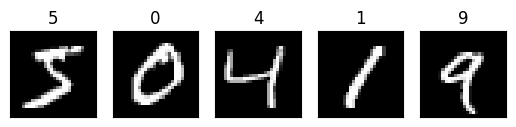

In [40]:
# visualize the data
import matplotlib.pyplot as plt
import numpy as np

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())

X_train, y_train = split_data_and_label(train_data)
X_test, y_test = split_data_and_label(test_data)

plot_example(X_train, y_train)

# Preparing the dataset

In [41]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()

# resize the dataset - flatten
X_train = X_train.view(-1, 784)
X_test = X_test.view(-1, 784)

# scaling the dataset
X_train = torch.Tensor(minmaxscaler.fit_transform(X_train))
X_test = torch.Tensor(minmaxscaler.transform(X_test))
print("Max:", torch.max(X_train).item())
print("Min:", torch.min(X_train).item())

Max: 1.0
Min: 0.0


The implementation chosen for this assignment is a **denoising autoencoder**, so below a method for adding gaussian noise to images is implemented

In [42]:
# add noise to the images
def add_noise(X, mean=0, std=1):
  noisy_imgs = X + torch.randn(X.shape)*std + mean 
  # Clip the images to be between 0 and 1
  noisy_imgs = np.clip(noisy_imgs, 0., 1.)
  return noisy_imgs

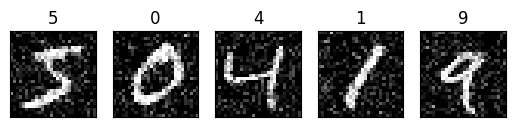

In [43]:
noise_std = 0.2
X_train_noisy = add_noise(X_train[:5], 0, noise_std)
plot_example(X_train_noisy, y_train)

# Utils

In [44]:
import torch.nn as nn
import torch.nn.functional as F

In [45]:
def evaluate_MSE(model, eval_dataset):
  with torch.no_grad():
    eval_output = model(eval_dataset)
    loss = F.mse_loss(eval_output, eval_dataset)
    
  return loss.item()

In [71]:
def fit(epochs, model, X_train, X_test=None):
  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(X_train, batch_size=20, shuffle=True)
  
  # define loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  print(model.parameters())

  train_loss_history = []
  test_loss_history = []
  
  for epoch in range(1, epochs+1):
    model.train()

    for images in train_loader:
      # reset gradient
      optimizer.zero_grad()

      # add noise
      noisy_images = add_noise(images, 0, noise_std)

      #forward pass
      output = model(noisy_images)
      loss = criterion(output, images)

      # optimizer step and backward pass
      loss.backward()
      optimizer.step()

    train_loss = evaluate_MSE(model, X_train)
    if X_test is not None:
      test_loss = evaluate_MSE(model, X_test)
      test_loss_history.append(test_loss)
      print(f'Epoch: {epoch} \tTraining Loss: {train_loss} \tTest Loss: {test_loss}')
    else:
      print(f'Epoch: {epoch} \tTraining Loss: {train_loss}')
    
    train_loss_history.append(train_loss)
    
  return [train_loss_history, test_loss_history]

In [48]:
# show a plot with 3 rows
# on the first row we will find an example of the input images with noise
# on the second row we will see images after the denoising process
# on the third row we will find the original images
def check_results(model, original, label):
  criterion = nn.MSELoss()
  input = add_noise(original, 0, noise_std)
  with torch.no_grad():
    denoised = model(input)
    loss = criterion(denoised, original) 

  rows = 3
  columns = 5

  fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 10))
  for i in range(rows):
      for j in range(columns):
          if i==0:
            axes[i, j].imshow(input[j].reshape(28, 28), cmap='gray')
            axes[i, j].set_title(label[j].item(), fontsize=20) 
          if i==1:
            axes[i, j].imshow(denoised[j].reshape(28, 28), cmap='gray')
          if i==2:
            axes[i, j].imshow(original[j].reshape(28, 28), cmap='gray')

          axes[i, j].tick_params(left = False, right = False , labelleft = False,
                  labelbottom = False, bottom = False)
          
  axes[0, 0].set_ylabel("INPUT", fontsize=20)        
  axes[1, 0].set_ylabel("DENOISED", fontsize=20)
  axes[2, 0].set_ylabel("ORIGINAL", fontsize=20)
  
  plt.show()

In [49]:
# counting the number of free params of the model
def count_parameters(model):
    free_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"The model has {free_params} free params")

In [50]:
# plot history
def plot_history(history):
  plt.plot(history[0])
  plt.plot(history[1])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Single Layer Autoencoder

In [51]:
class Autoencoder(nn.Module):
  """
    This class implements the single layer AutoEncoder made of a
    first dense layer (input_dim, encoding_dim) that implements the econder
    and a second dense layer (encoding_dim, input_dim) for the decoder

    Args:
        input_dim (int): integer that rapresents the dimesion of the input data.
        enc_dim (int): integer that rapresents the dimesion of the latent space.
  """

  def __init__(self, input_dim, enc_dim, last_layer=True):
    super(Autoencoder, self).__init__()
    self.last_layer = last_layer
    self.input_dim = input_dim
    self.enc_dim = enc_dim
    # encoder made of one linear layer that maps a vector of size input dim into a vector of size enc_dim
    self.encoder = nn.Linear(input_dim, enc_dim)
    # the decoder will reconstruct the image in the original space
    self.decoder = nn.Linear(enc_dim, input_dim)

    self.enc_activation = nn.ReLU()

    if self.last_layer:
      self.dec_act = nn.Sigmoid()
    else:
      self.dec_act = nn.ReLU()
   
  def encode(self, x):
    x = self.encoder(x)
    x = self.enc_activation(x)
    return x
  
  def decode(self, x):
    x = self.decoder(x)
    x = self.dec_act(x)
    return x

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x

To make the comparison between the two models, they need to have a similar number of free parameters.
I then print the number of free parameters of the model so that I can later create a deep autoencoder with the same number of free parameters

In [52]:
sae = Autoencoder(X_train.shape[1], 400)
count_parameters(sae)

The model has 628384 free params


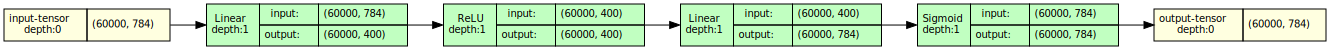

In [53]:
model_graph = draw_graph(sae, input_size=X_train.shape, expand_nested=True, graph_dir='LR')
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [54]:
epochs = 10
history = fit(epochs, sae, X_train, X_test)

<generator object Module.parameters at 0x7f661a0d8270>
Epoch: 1 	Training Loss: 0.029866214841604233 	Test Loss: 0.029489492997527122
Epoch: 2 	Training Loss: 0.013626876287162304 	Test Loss: 0.013598510064184666
Epoch: 3 	Training Loss: 0.005015552043914795 	Test Loss: 0.005134585313498974
Epoch: 4 	Training Loss: 0.003817441873252392 	Test Loss: 0.003955697640776634
Epoch: 5 	Training Loss: 0.0034607318229973316 	Test Loss: 0.003619831521064043
Epoch: 6 	Training Loss: 0.0031529609113931656 	Test Loss: 0.0033207694068551064
Epoch: 7 	Training Loss: 0.0030319555662572384 	Test Loss: 0.0032093124464154243
Epoch: 8 	Training Loss: 0.003040986368432641 	Test Loss: 0.003224132116883993
Epoch: 9 	Training Loss: 0.002805683994665742 	Test Loss: 0.002989046508446336
Epoch: 10 	Training Loss: 0.002726492239162326 	Test Loss: 0.002915846649557352


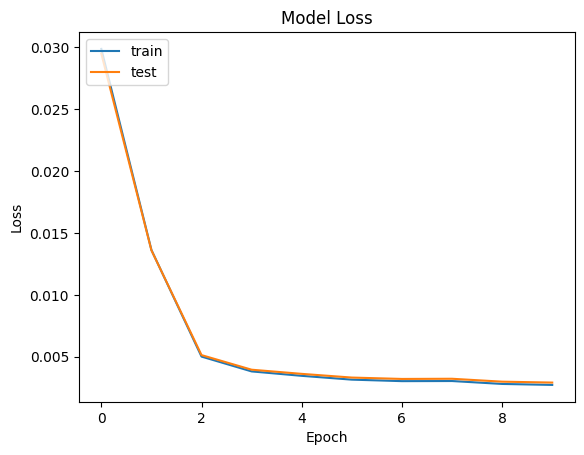

In [55]:
plot_history(history)

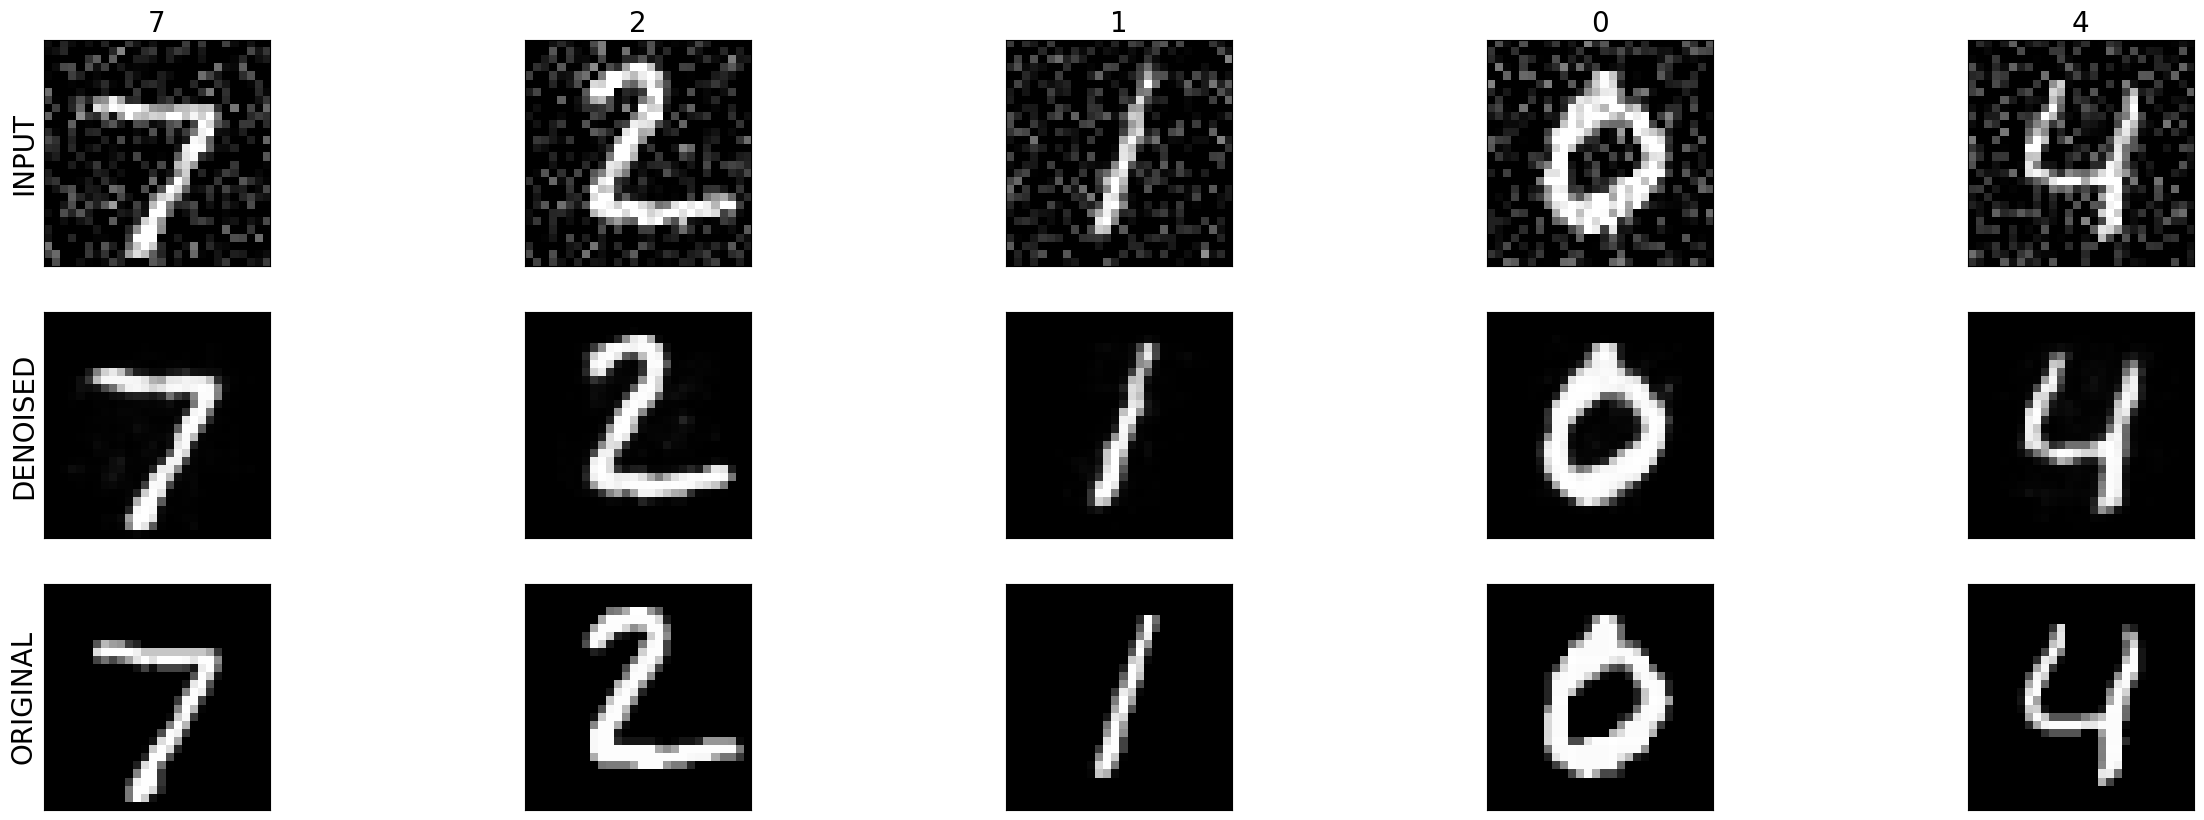

In [56]:
check_results(model=sae, original=X_test, label=y_test)

# Deep AutoEncoder with only layerwise pretraining

In [81]:
class DeepAutoEncoder(nn.Module):
  """
    This class implements the DeepAutoEncoder as a list of Single Layer Autoencoder

    Args:
        input_dim (int): integer that rapresents the dimesion of the input data.
        hidden_layers (list(int)): the length of the list defines the numbers of hidden layer
                                   each element of the list defines the latent space dimension of each layer.
  """

  def __init__(self, input_dim, hidden_layers):
    super().__init__()

    # first layer, the decoder will reconstruct the image
    self.autoencoders = [Autoencoder(input_dim, hidden_layers[0], False)]
    print(f"Adding autoencoder with dim {input_dim} {hidden_layers[0]}")
    input_dim = hidden_layers[0]
    hidden_layers.pop(0)

    for elem in hidden_layers:
      print(f"Adding autoencoder with dim {input_dim} {elem}")
      self.autoencoders.append(Autoencoder(input_dim, elem, False))
      input_dim = elem
      
    self.model = nn.ModuleList(self.autoencoders)
  
  def encode(self, x):
    enc = x
    for ae in self.model:
      enc = ae.encode(enc)
    return enc

  def decode(self, x):
    dec = x
    # reverse list of models and decode
    for ae in self.model[::-1]:
      dec = ae.decode(dec)
    return dec

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x



In [82]:
# number of parameters of single layer autoencoder 628384
hidden_layers = [300, 200, 90]
deep_ae = DeepAutoEncoder(X_train.shape[1], hidden_layers)
count_parameters(deep_ae)

Adding autoencoder with dim 784 300
Adding autoencoder with dim 300 200
Adding autoencoder with dim 200 90
The model has 628274 free params


In [83]:
model_graph = draw_graph(deep_ae, input_size=X_train.shape, expand_nested=True, graph_dir='LR')
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [85]:
data_in = X_train
data_in_test = X_test
for ae in deep_ae.model:
  fit(2, ae, data_in, data_in_test)

  # create latent rappresentation of data
  # the new encoded data_in will be passed to the data loader in the fit method
  with torch.no_grad():
    data_in = ae.encode(data_in)
    data_in_test = ae.encode(data_in_test)
    


<generator object Module.parameters at 0x7f6619f80970>
Epoch: 1 	Training Loss: 0.019832268357276917 	Test Loss: 0.01998569443821907
Epoch: 2 	Training Loss: 0.02022404782474041 	Test Loss: 0.02040054276585579
<generator object Module.parameters at 0x7f6619f80b30>
Epoch: 1 	Training Loss: 0.02178235724568367 	Test Loss: 0.021921535953879356
Epoch: 2 	Training Loss: 0.021455936133861542 	Test Loss: 0.021693553775548935
<generator object Module.parameters at 0x7f6619f80970>
Epoch: 1 	Training Loss: 0.037612900137901306 	Test Loss: 0.038004424422979355
Epoch: 2 	Training Loss: 0.04029475152492523 	Test Loss: 0.04087427631020546


# Deep AutoEncoder with Fine Tuning

In [61]:
history = fit(epochs, deep_ae, X_train, X_test)

<generator object Module.parameters at 0x7f661a89bc30>
Epoch: 1 	Training Loss: 0.025273729115724564 	Test Loss: 0.025030111894011497
Epoch: 2 	Training Loss: 0.025478048250079155 	Test Loss: 0.02529437653720379
Epoch: 3 	Training Loss: 0.025357166305184364 	Test Loss: 0.025223325937986374
Epoch: 4 	Training Loss: 0.028890948742628098 	Test Loss: 0.028723709285259247
Epoch: 5 	Training Loss: 0.03153933584690094 	Test Loss: 0.03138817846775055
Epoch: 6 	Training Loss: 0.031990110874176025 	Test Loss: 0.031777989119291306
Epoch: 7 	Training Loss: 0.032878123223781586 	Test Loss: 0.032687313854694366
Epoch: 8 	Training Loss: 0.033031586557626724 	Test Loss: 0.03288776054978371
Epoch: 9 	Training Loss: 0.03653779253363609 	Test Loss: 0.03630746155977249
Epoch: 10 	Training Loss: 0.036747582256793976 	Test Loss: 0.03655634820461273


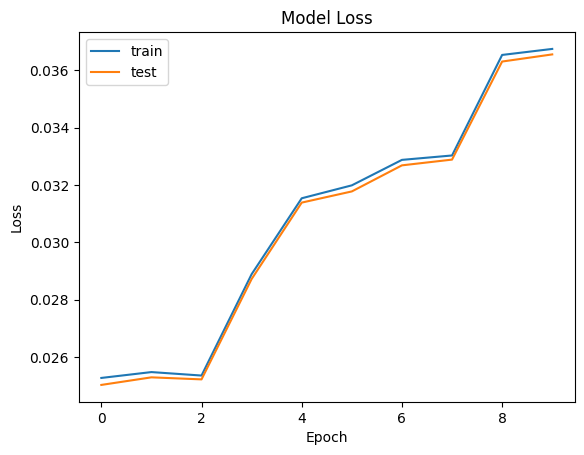

In [62]:
plot_history(history)

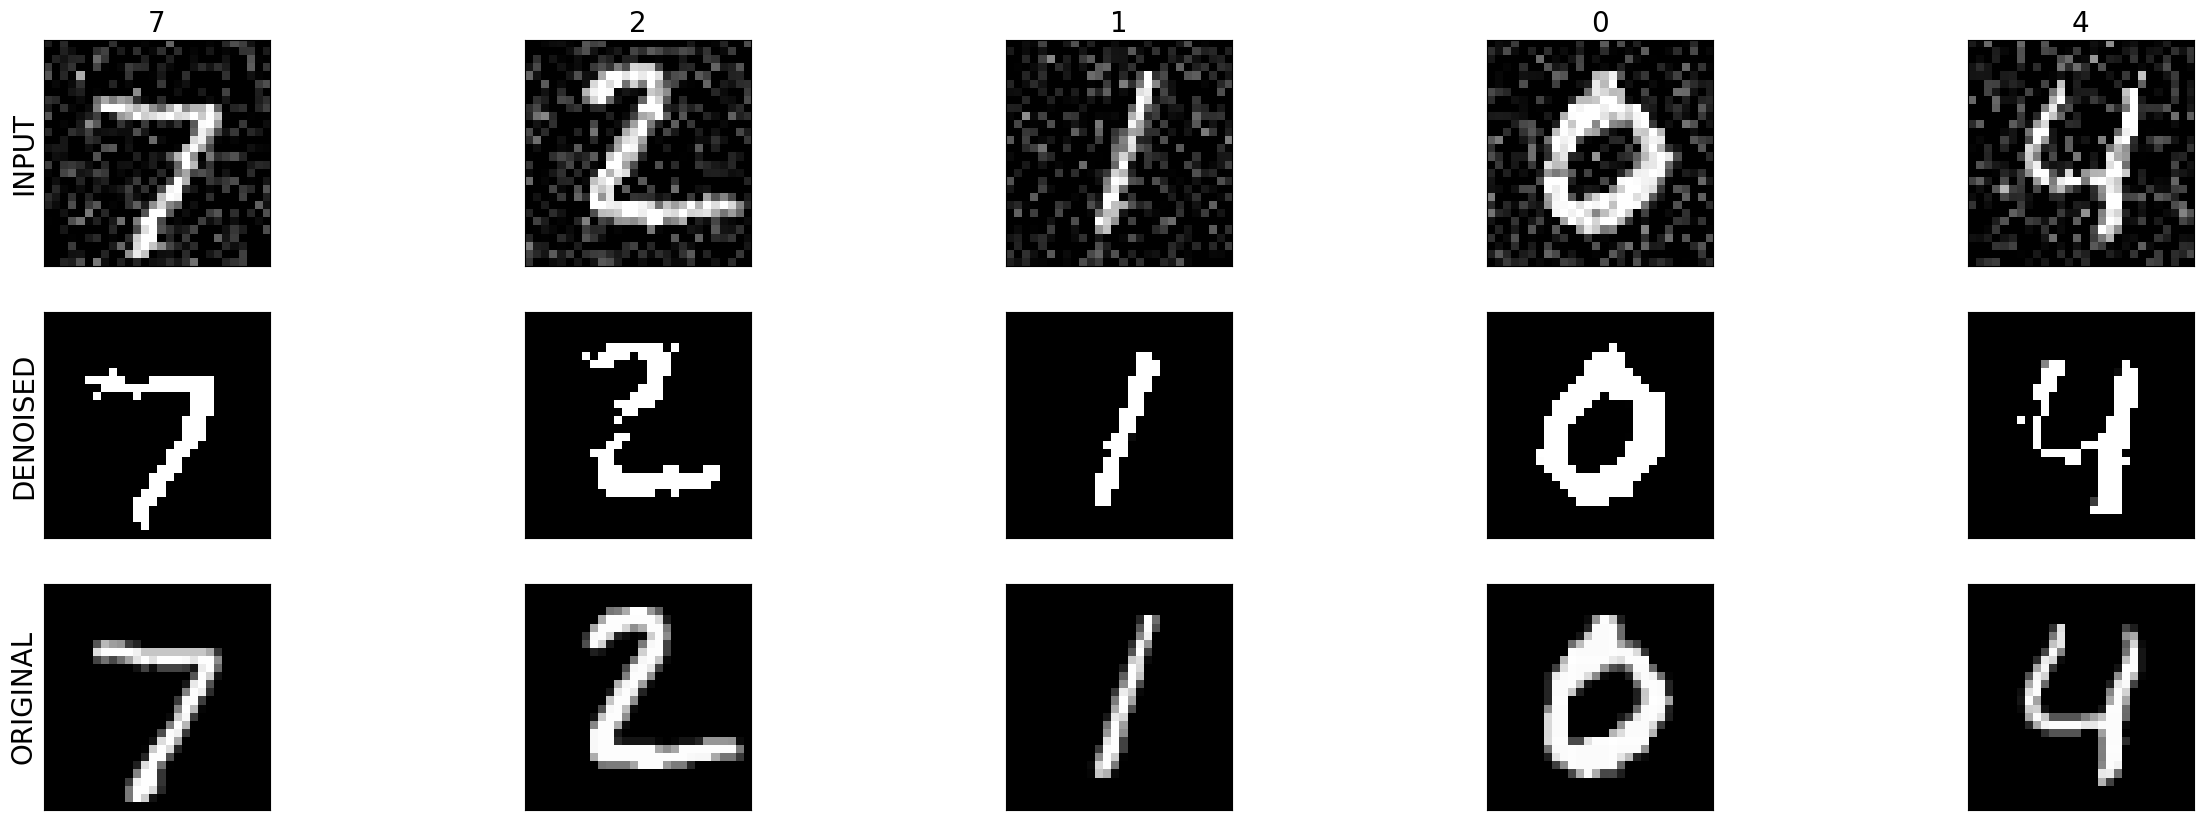

In [63]:
check_results(model=deep_ae, original=X_test, label=y_test)

# Latent Space Interpolation

Given the encoding z1 of image x1 (obtained in the hidden layer of the autoencoder) and z2 of image x2, a latent space interpolation is an encoding that is obtained with the linear interpolation z* = a*z1 + (1 - a)*z2, with a in [0, 1]. Perform a latent space interpolation (with some choices of a) using:
- z1 and z2 from the same class
- z1 and z2 from different classes

Once you have the interpolated encoding z* visualize its image reconstructions (obtained through the decoder) and discuss the results.

In [64]:
def plot_interpolations(X, alphas):
    """Plot 5 images in a row."""
    for i, img in enumerate(X):
        img = img.reshape((28, 28))
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.title(f"alpha: {alphas[i]}")

In [65]:
def compute_interpolation(model, img1, img2):
  with torch.no_grad():
    encoding1 = model.encode(img1)
    encoding2 = model.encode(img2)

    # trying different values of alphas
    values = 5
    alphas = []
    interpolated_images = []
    for i in range(values):
      alpha = i/5
      alphas.append(alpha)
      interpolation = alpha *encoding1 + (1 - alpha)*encoding2
    
      #compute decoding starting from the interpolation
      result = model.decode(interpolation)
      interpolated_images.append(result)

    plot_interpolations(interpolated_images, alphas)

## Interpolation using images of the same class

In [66]:
# choose two images of the class 5

# Find indices of all examples with label 5
idx_5 = (y_test == 5)

# Filter X_test to get examples with label 5
X_test_5 = X_test[idx_5]
X_test_5.shape

torch.Size([892, 784])

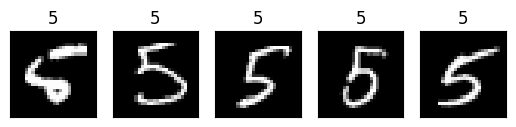

In [67]:
plot_example(X_test_5, y_test[idx_5])

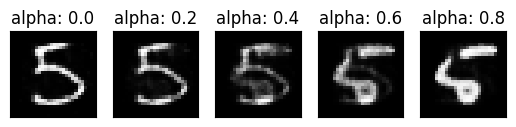

In [68]:
# select the first two images
img1 = X_test_5[0]
img2 = X_test_5[1]

# to show the result of a latent space interpolation 
# I choose as models the single layer autoencoder trained before
# compute latent space rapresentation for two different images
compute_interpolation(sae, img1, img2)

## Interpolation using images of different classes

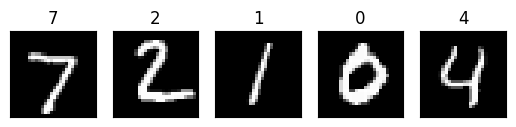

In [69]:
plot_example(X_test, y_test)

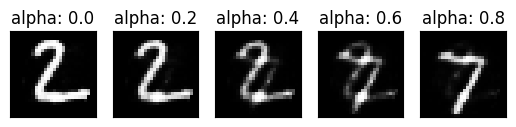

In [70]:
# select the first two images 
img1 = X_test[0]
img2 = X_test[1]

# to show the result of a latent space interpolation 
# I choose as models the single layer autoencoder trained before
# compute latent space rapresentation for two different images
compute_interpolation(sae, img1, img2)

# Conclusions

In questo notebook è stata presentata l'implementazione di un autoencoder utilizzando PyTorch sul dataset di MNIST.
Gli AutoEncoder implementati sono un single layer autoencoder, un deep autoencoder utilizzando il layerwise pretraining e infine è stato eseguito del finetuning sul deep autoencoder.
Il single layer autoencoder viene implementato con un livello denso per la parte di encoding ed un livello denso per la parte di decoding.
Il deep autoencoder è stato implementato impilando uno dopo l'altro dei modelli di single layer autoencoder e considerando come input per l'hidden layer i, l'encoder del hidden layer i-1.
Il confronto tra questi modelli viene eseguito 